In [94]:
%matplotlib widget
import sys
import os
import subprocess
import torch
import numpy as np
import fileinput
import matplotlib.pyplot as plt
import torch.distributed as dist
import models
from dfd_utils.FaceForensicsDataset import FaceForensicsDataset
from dfd_utils.utils import plot_images, get_embeddings, plot_embeddings_2D, plot_embeddings_3D
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 

from sklearn.manifold import TSNE
from matplotlib import cm

from torchvision import transforms, utils, datasets
import cv2
from facenet_pytorch import MTCNN
import random

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install tabulate
!pip install configargparse
!pip install filelock
!pip install strconv

In [47]:
CONFIG_FILE_PATH = "/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/generic_config.yaml"
#cifar_train_epochs1000_bs1024.yaml
#ff_train.yaml

In [20]:
# Modify params in the file
batch_size = 32
eval_only = True

## Train Base Model

In [16]:
cmd = f'python train.py --config {CONFIG_FILE_PATH}'
!{cmd}

args: Namespace(ckpt='', config_file='./configs/cifar_train_epochs1000_bs1024.yaml', deepfakes=False, dist='ddp', dist_address='127.0.0.1:1234', eval_freq=4800, eval_only=False, iters=48000, log_freq=48, lr=4.0, lr_schedule='warmup-anneal', name='reproduce-cifar10', node_rank=0, opt='lars', problem='sim-clr', save_freq=4800, seed=-1, tmp=False, verbose=True, warmup=0.01, weight_decay=1e-06, workers=2, world_size=1)
arch: ResNet50
aug: true
batch_size: 128
ckpt: ''
color_dist_s: 0.5
config_file: ./configs/cifar_train_epochs1000_bs1024.yaml
data: cifar
deepfakes: false
dist: ddp
dist_address: 127.0.0.1:1234
eval_freq: 4800
eval_only: false
iters: 48000
log_freq: 48
lr: 4.0
lr_schedule: warmup-anneal
multiplier: 2
name: reproduce-cifar10
node_rank: 0
opt: lars
problem: sim-clr
root: /srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/logs/exman-train.py/runs/000143
save_freq: 4800
scale_lower: 0.08
seed: -1
sync_bn: true
temperature: 0.5
tmp: false
verbose: true
warmup: 0.0

## Eval Base Model

In [17]:
# Eval base modelb
cmd = f'python train.py --config {CONFIG_FILE_PATH} --eval_only True'
!{cmd}

args: Namespace(ckpt='', config_file='./configs/cifar_train_epochs1000_bs1024.yaml', deepfakes=False, dist='ddp', dist_address='127.0.0.1:1234', eval_freq=4800, eval_only=True, iters=48000, log_freq=48, lr=4.0, lr_schedule='warmup-anneal', name='reproduce-cifar10', node_rank=0, opt='lars', problem='sim-clr', save_freq=4800, seed=-1, tmp=False, verbose=True, warmup=0.01, weight_decay=1e-06, workers=2, world_size=1)
arch: ResNet50
aug: true
batch_size: 128
ckpt: ''
color_dist_s: 0.5
config_file: ./configs/cifar_train_epochs1000_bs1024.yaml
data: cifar
deepfakes: false
dist: ddp
dist_address: 127.0.0.1:1234
eval_freq: 4800
eval_only: true
iters: 48000
log_freq: 48
lr: 4.0
lr_schedule: warmup-anneal
multiplier: 2
name: reproduce-cifar10
node_rank: 0
opt: lars
problem: sim-clr
root: /srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/logs/exman-train.py/runs/000144
save_freq: 4800
scale_lower: 0.08
seed: -1
sync_bn: true
temperature: 0.5
tmp: false
verbose: true
warmup: 0.01


In [ ]:
# Train classificaiton Head

In [ ]:
# Load checkpoint

## Plot Embeddings

### Load Model

In [108]:
plt.rcParams['figure.dpi']=300
device = torch.device('cuda')
dist.init_process_group(
            backend='nccl',
            init_method='tcp://%s' % 'localhost:8881',
            world_size=1,
            rank=0,
        )

RuntimeError: trying to initialize the default process group twice!

In [106]:
MODELS_FOLDER = '/media/shirbar/My Passport/trained_models'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

chkpt_path = '/media/shirbar/My Passport/trained_models/simclr_original_augs_pretrained_resnet.pth.tar'
print('loading checkpoint:', chkpt_path, ' ...')
chkpt = torch.load(chkpt_path,
                    map_location=device)
print('checkpoint loaded!')

print('loading model...')
model = models.ssl.SimCLR.load(chkpt, device=device)
model.eval()
print('model loaded!')

loading checkpoint: /media/shirbar/My Passport/trained_models/simclr_original_augs_pretrained_resnet.pth.tar  ...
checkpoint loaded!
loading model...
device is: cuda
ddp
** Removing original FC layer **
** Using avgpool **
** Loading pretrained ResNet50 weights **
======> Encoder: output dim 2048 | 23.508M parameters
ssl.__init__:device is: cuda
hparams.gpu : 0
model loaded!


### Load torchvision model

In [22]:
import torchvision.models as torchmodels

In [50]:
model = torchmodels.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/leva1/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [51]:
#model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Load FaceForensics Dataset

In [96]:
def load_ff_ds_test(wanted_ds_size,
                    batch_size,
                    load_deepfakes=False,
                    load_face2face=False,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=None):
    TEST_DATASET_PATH = '/media/shirbar/My Passport/FaceForensics/split_ds/test'
    ff_ds_test  = FaceForensicsDataset(TEST_DATASET_PATH,
                                    transform=None,
                                    load_deepfakes=load_deepfakes,
                                    load_face2face=load_face2face,
                                    load_neural_textures=load_neural_textures,
                                  masking_transforms=masking_transforms)
    
    ff_ds_test.equalize_real_fakes()
    #"""
    test_size = int(0.8 * len(ff_ds_test))
    ts_size = len(ff_ds_test) - test_size

    test_dataset,_ = torch.utils.data.random_split(ff_ds_test, [test_size, ts_size], generator=torch.Generator().manual_seed(42))
    test_subset = Subset(test_dataset, list(range(0, wanted_ds_size)))
    #"""
    """
    ff_ds_test_len = len(ff_ds_test)
    wanted_ds_size = wanted_ds_size if ff_ds_test_len > wanted_ds_size else ff_ds_test_len
    random.seed(42)
    random_indices = random.sample(range(0,ff_ds_test_len), wanted_ds_size)

    test_subset = Subset(ff_ds_test, random_indices)
    """
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle = False)

    print('test size:', test_subset.__len__())
    return test_loader

## Deepfakes

In [110]:
test_loader = load_ff_ds_test(1000, 16, load_deepfakes=True)

loading real images...
real images loaded!
loading deepfakes...
deepfakes loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 1000


In [111]:
embeds, targets = get_embeddings(model, test_loader, device, out='z')

100%|██████████| 63/63 [01:34<00:00,  1.51s/it]


In [20]:
save_path = '/media/shirbar/My Passport/trained_models/embeddings/simclr_original_augs_pretrained_resnet_embeddings_real_deepfakes.pt'
torch.save({'embeddings': embeds, 'targets':targets},
          save_path)

### Plot example images

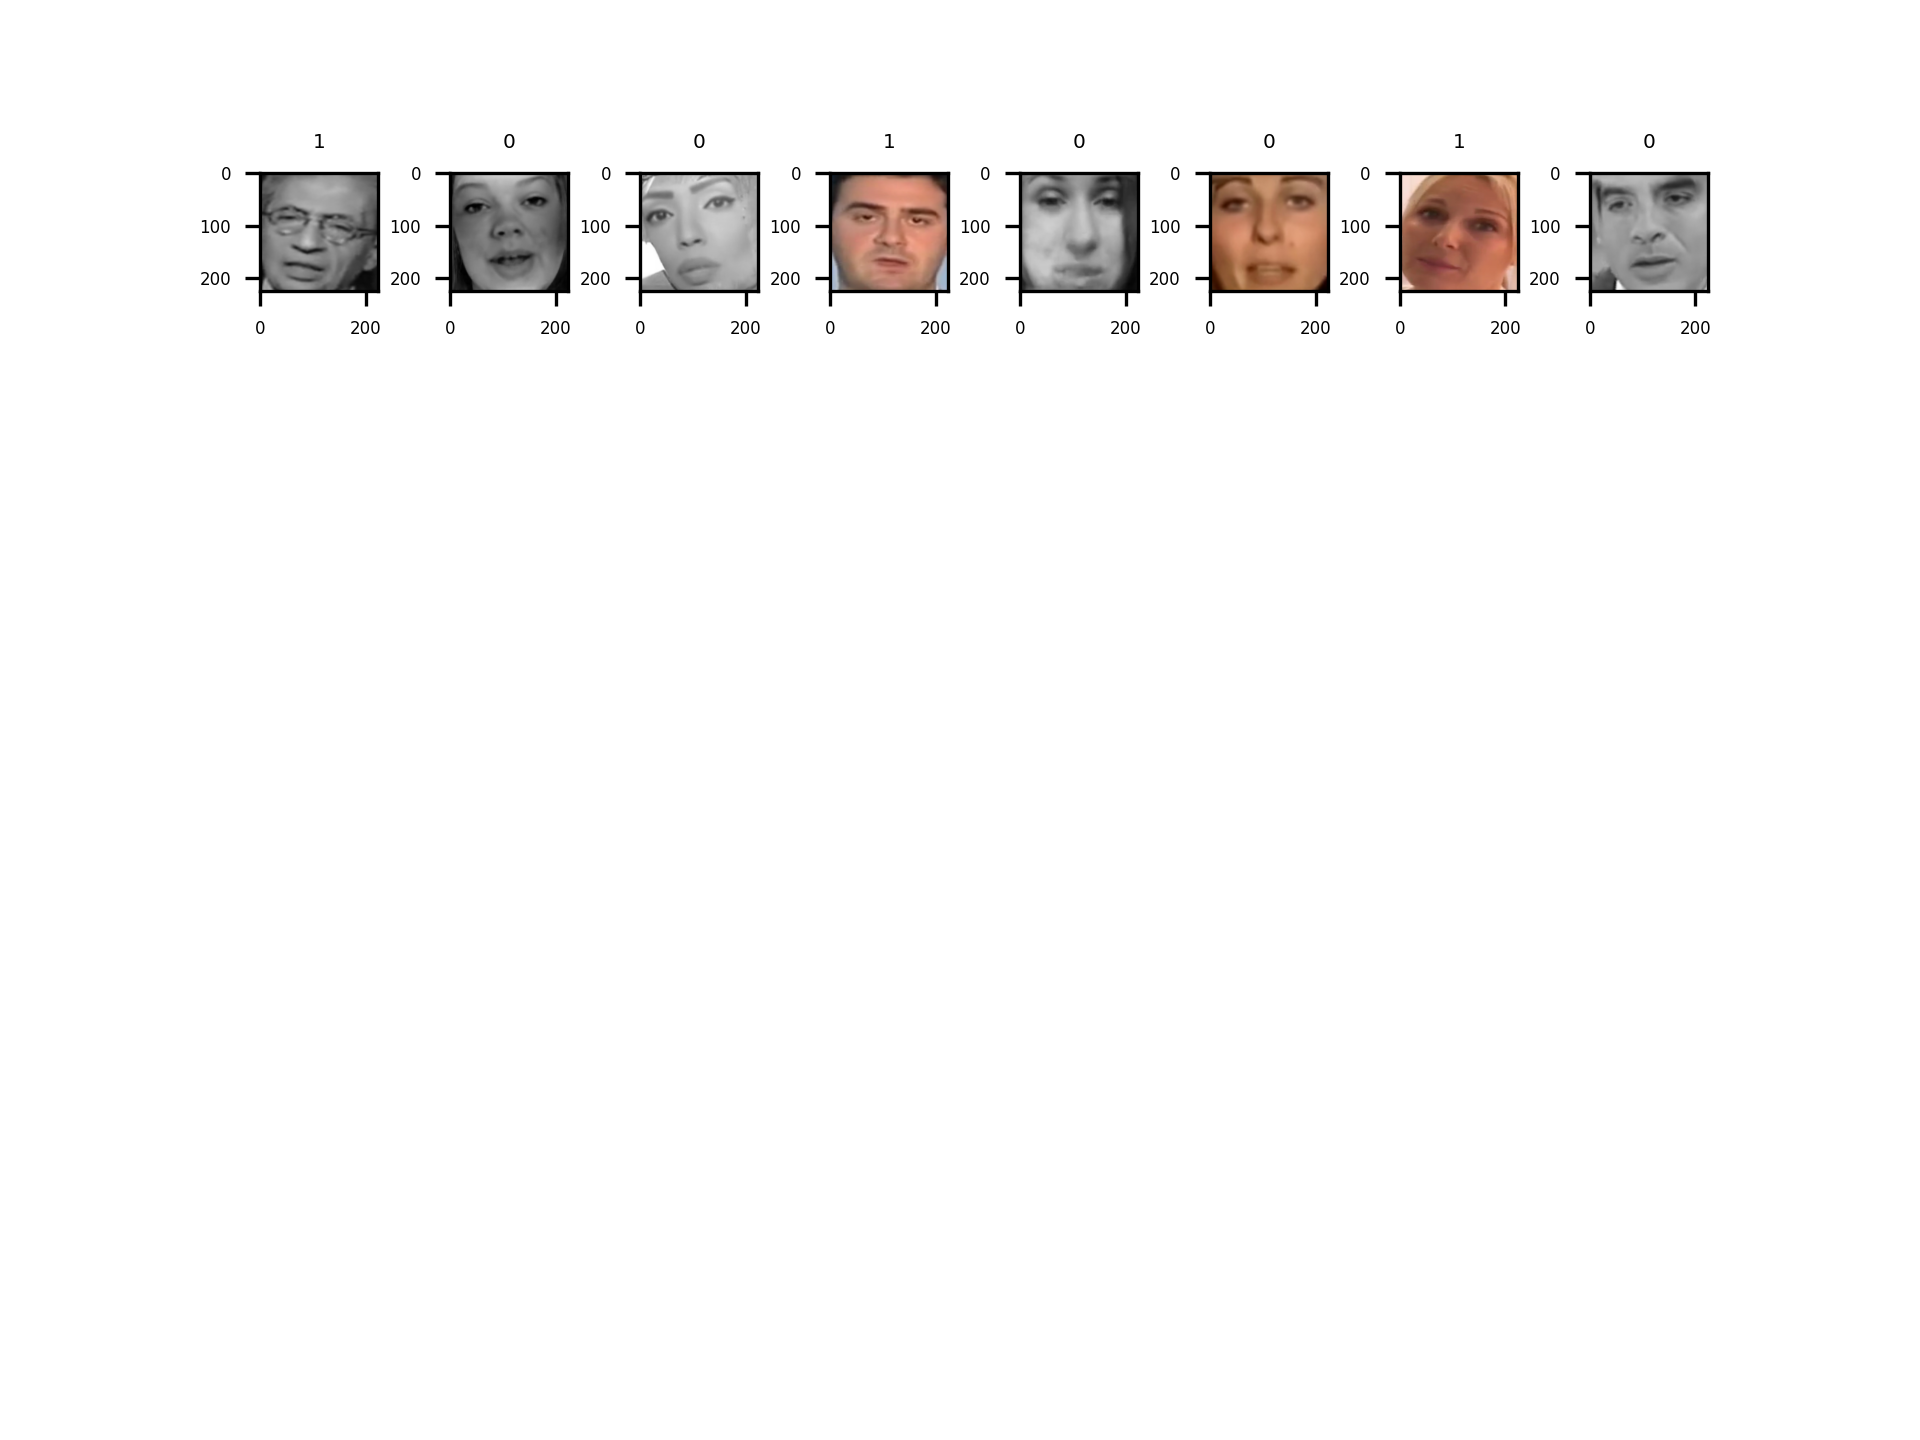

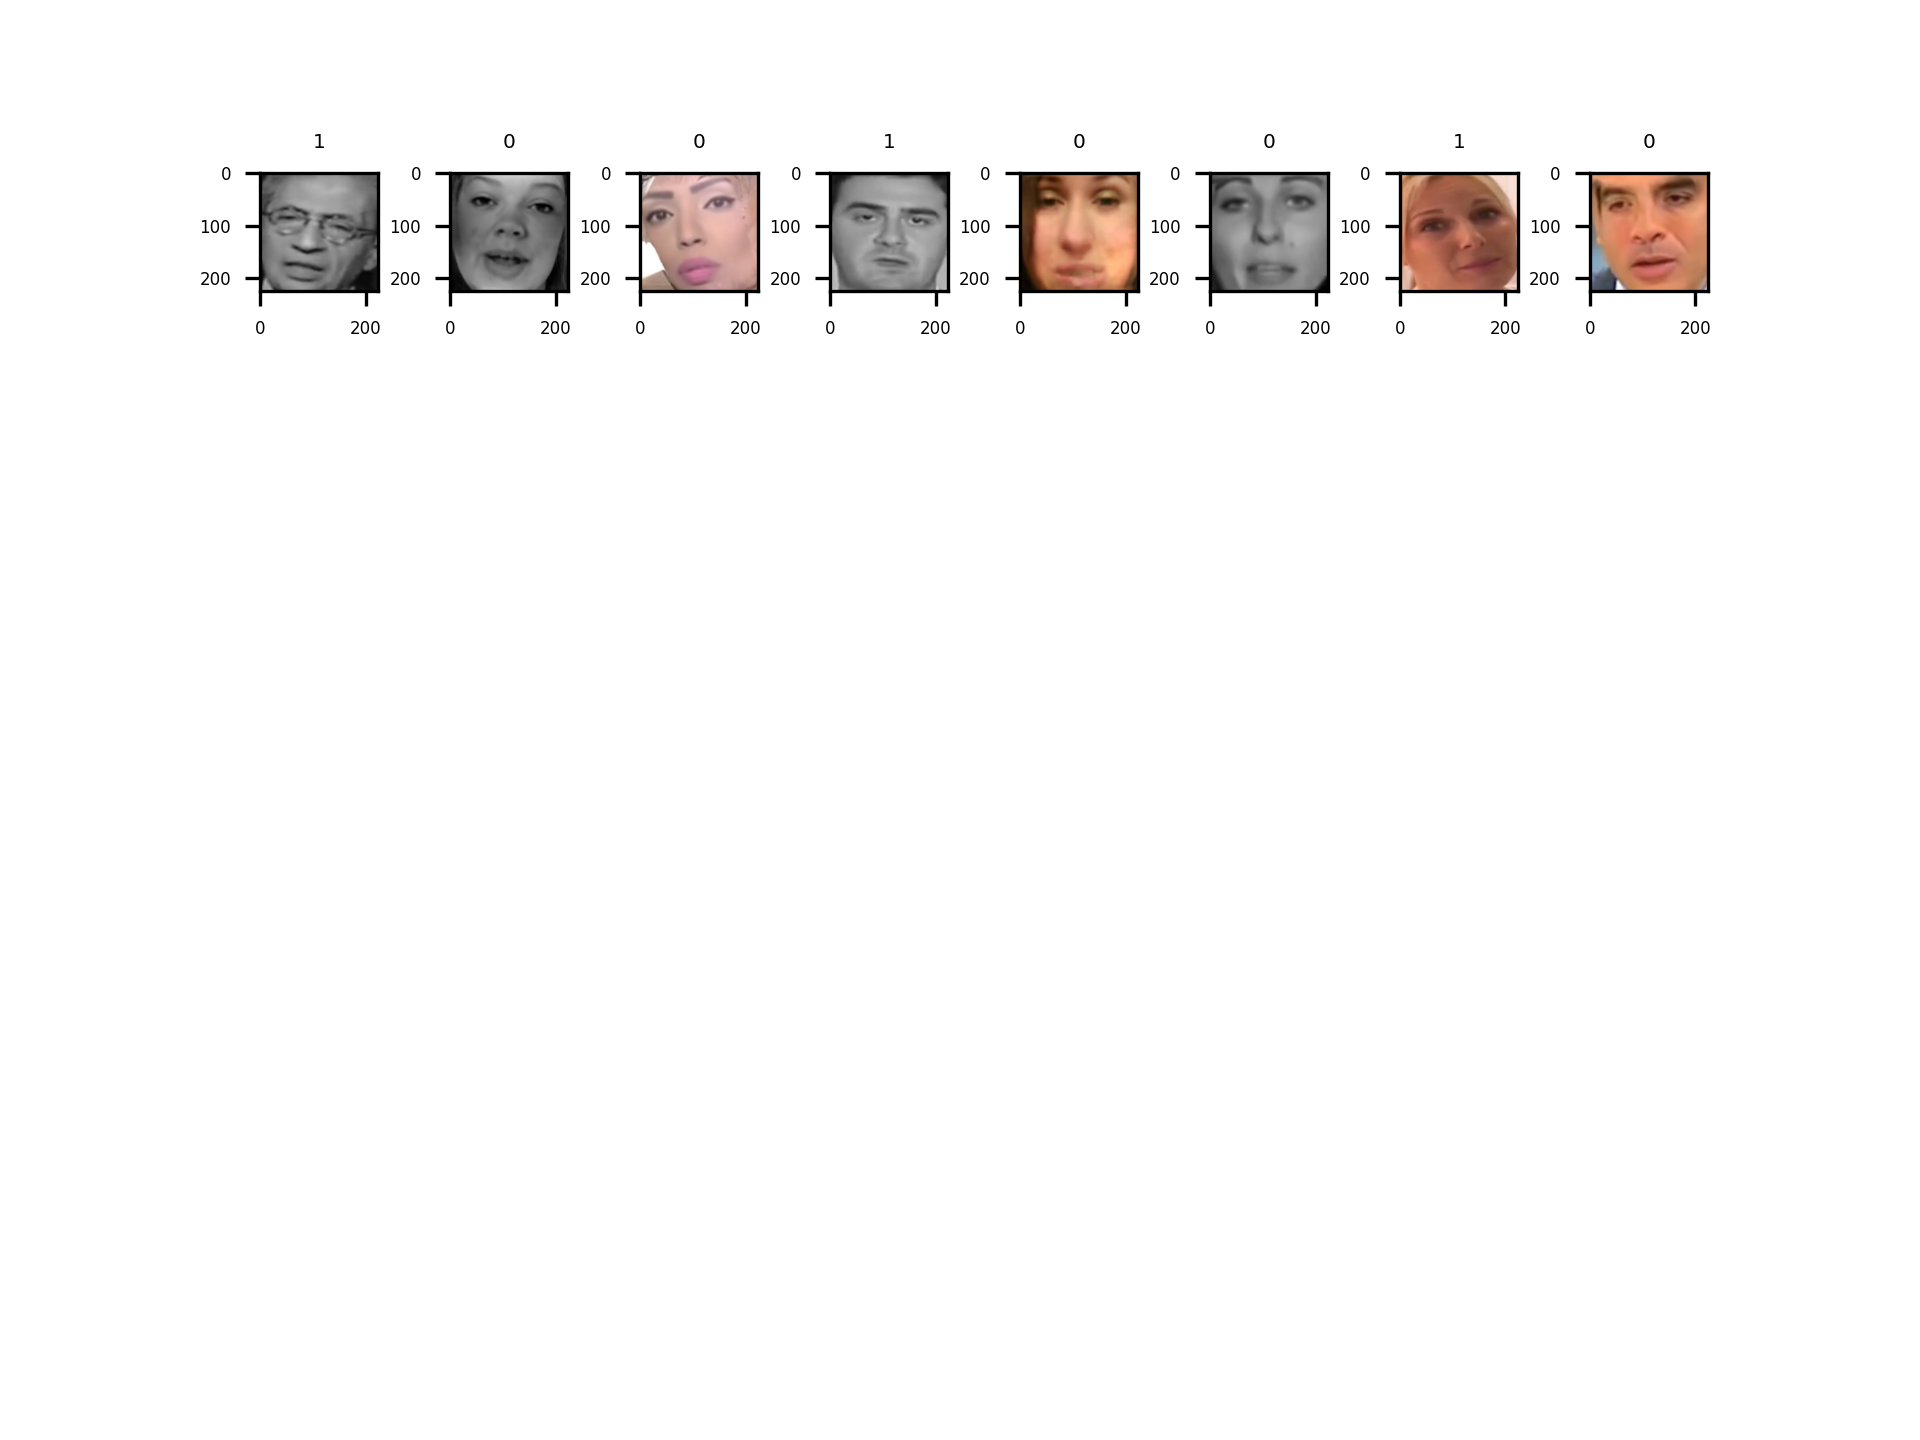

In [104]:
images1, images2, labels = next(iter(test_loader))
plot_images(images1, labels.tolist(), max_num_images_to_plt=8)
plot_images(images2, labels.tolist(), max_num_images_to_plt=8)

### 2D Embeddings - Deepfakes + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.118041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.787163
[t-SNE] KL divergence after 1000 iterations: 0.906858


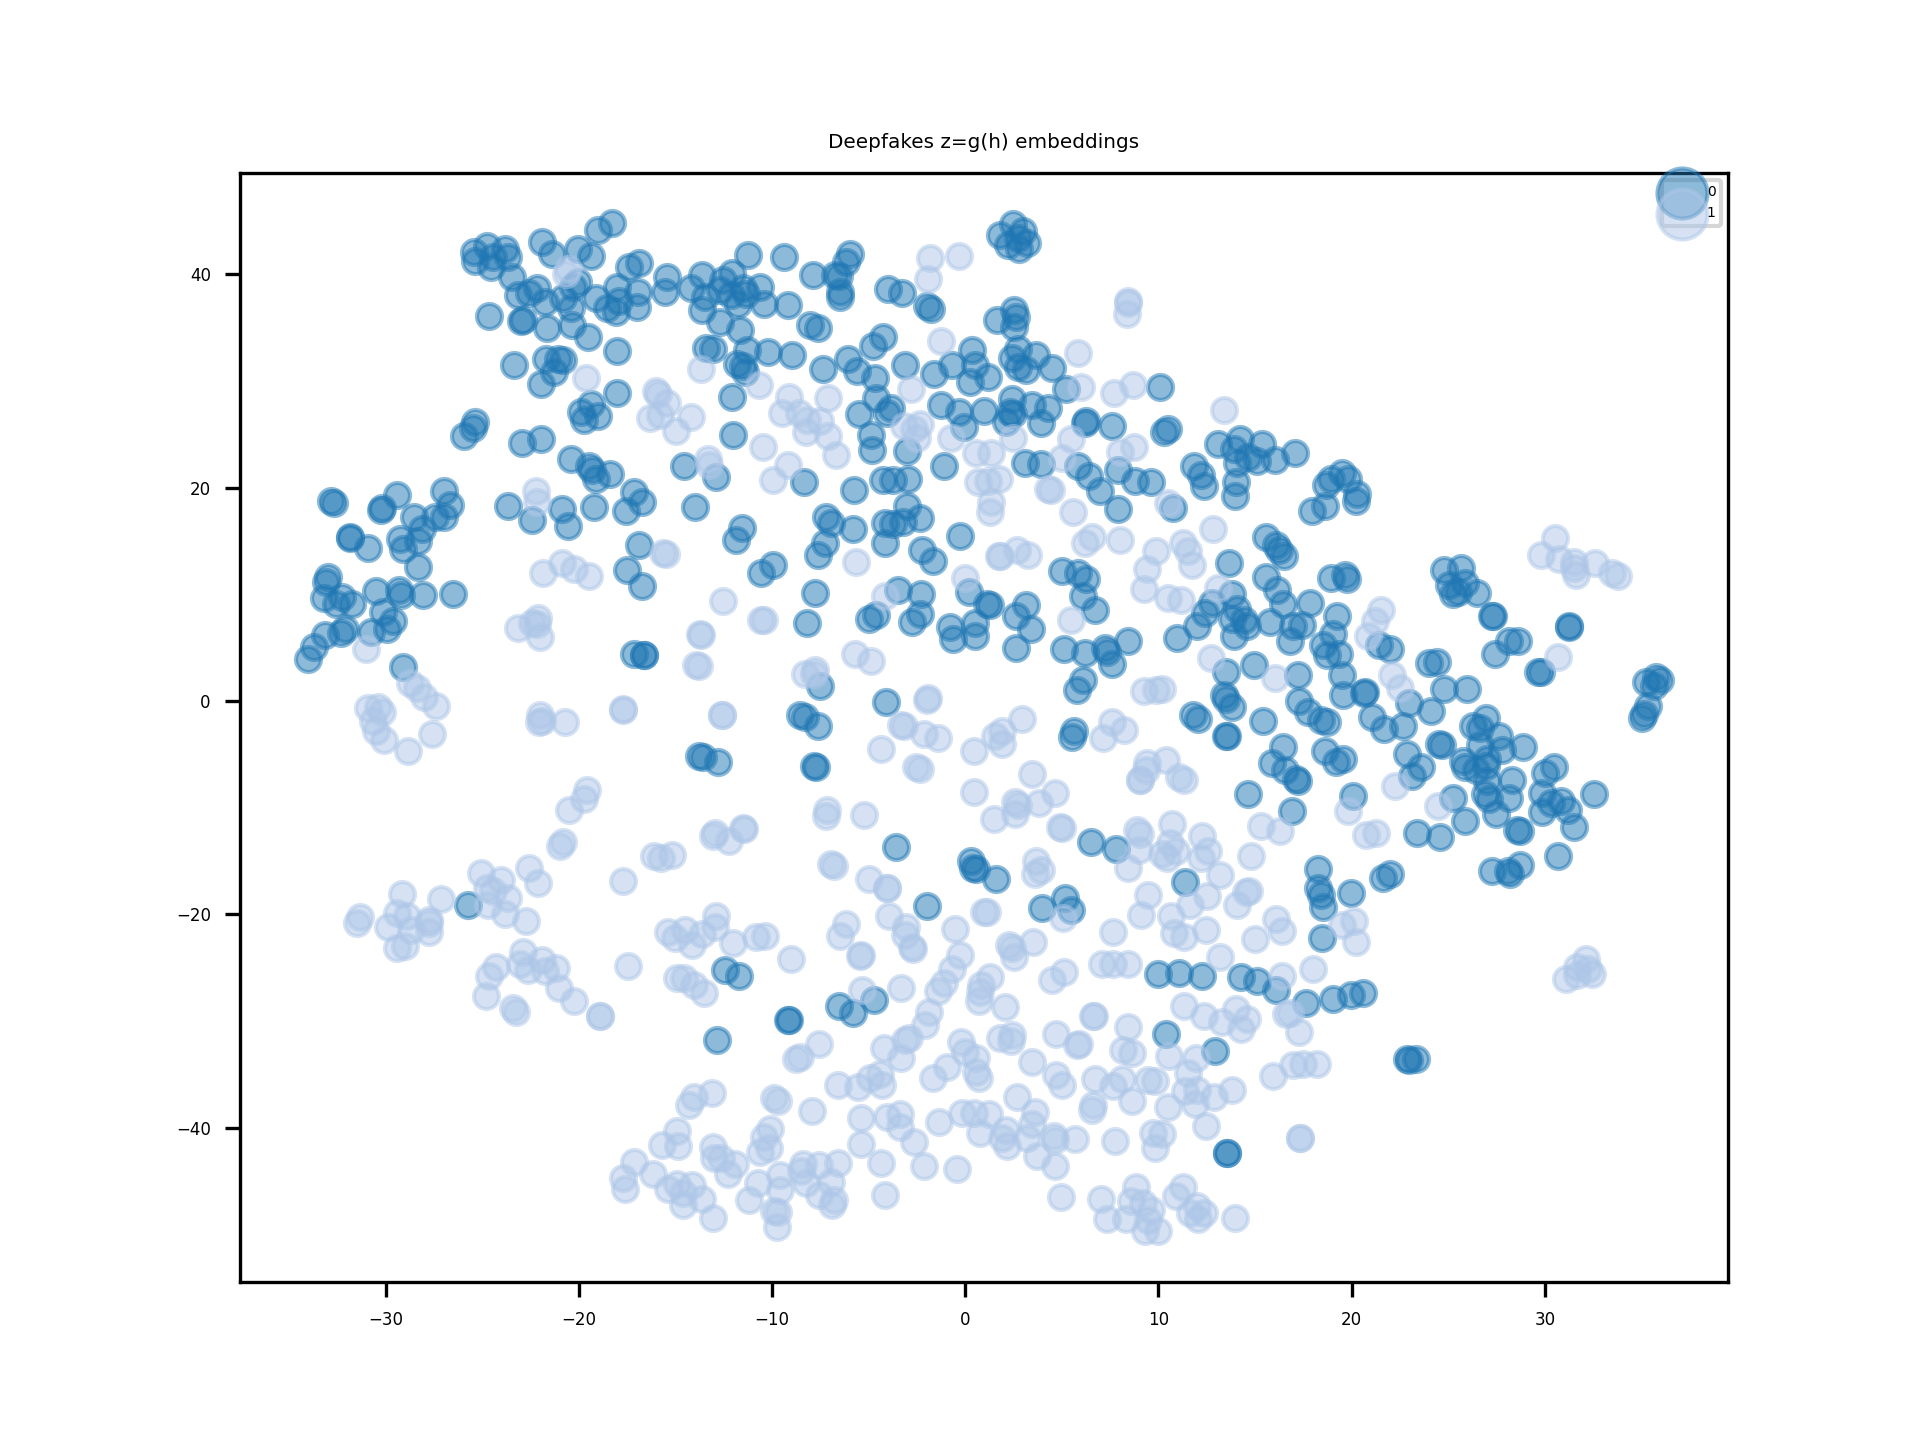

In [113]:
plot_embeddings_2D(embeds, targets, 'Deepfakes z=g(h) embeddings')

### 3D Embeddings - Deepfakes + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.118041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.946648
[t-SNE] KL divergence after 1000 iterations: 0.734801


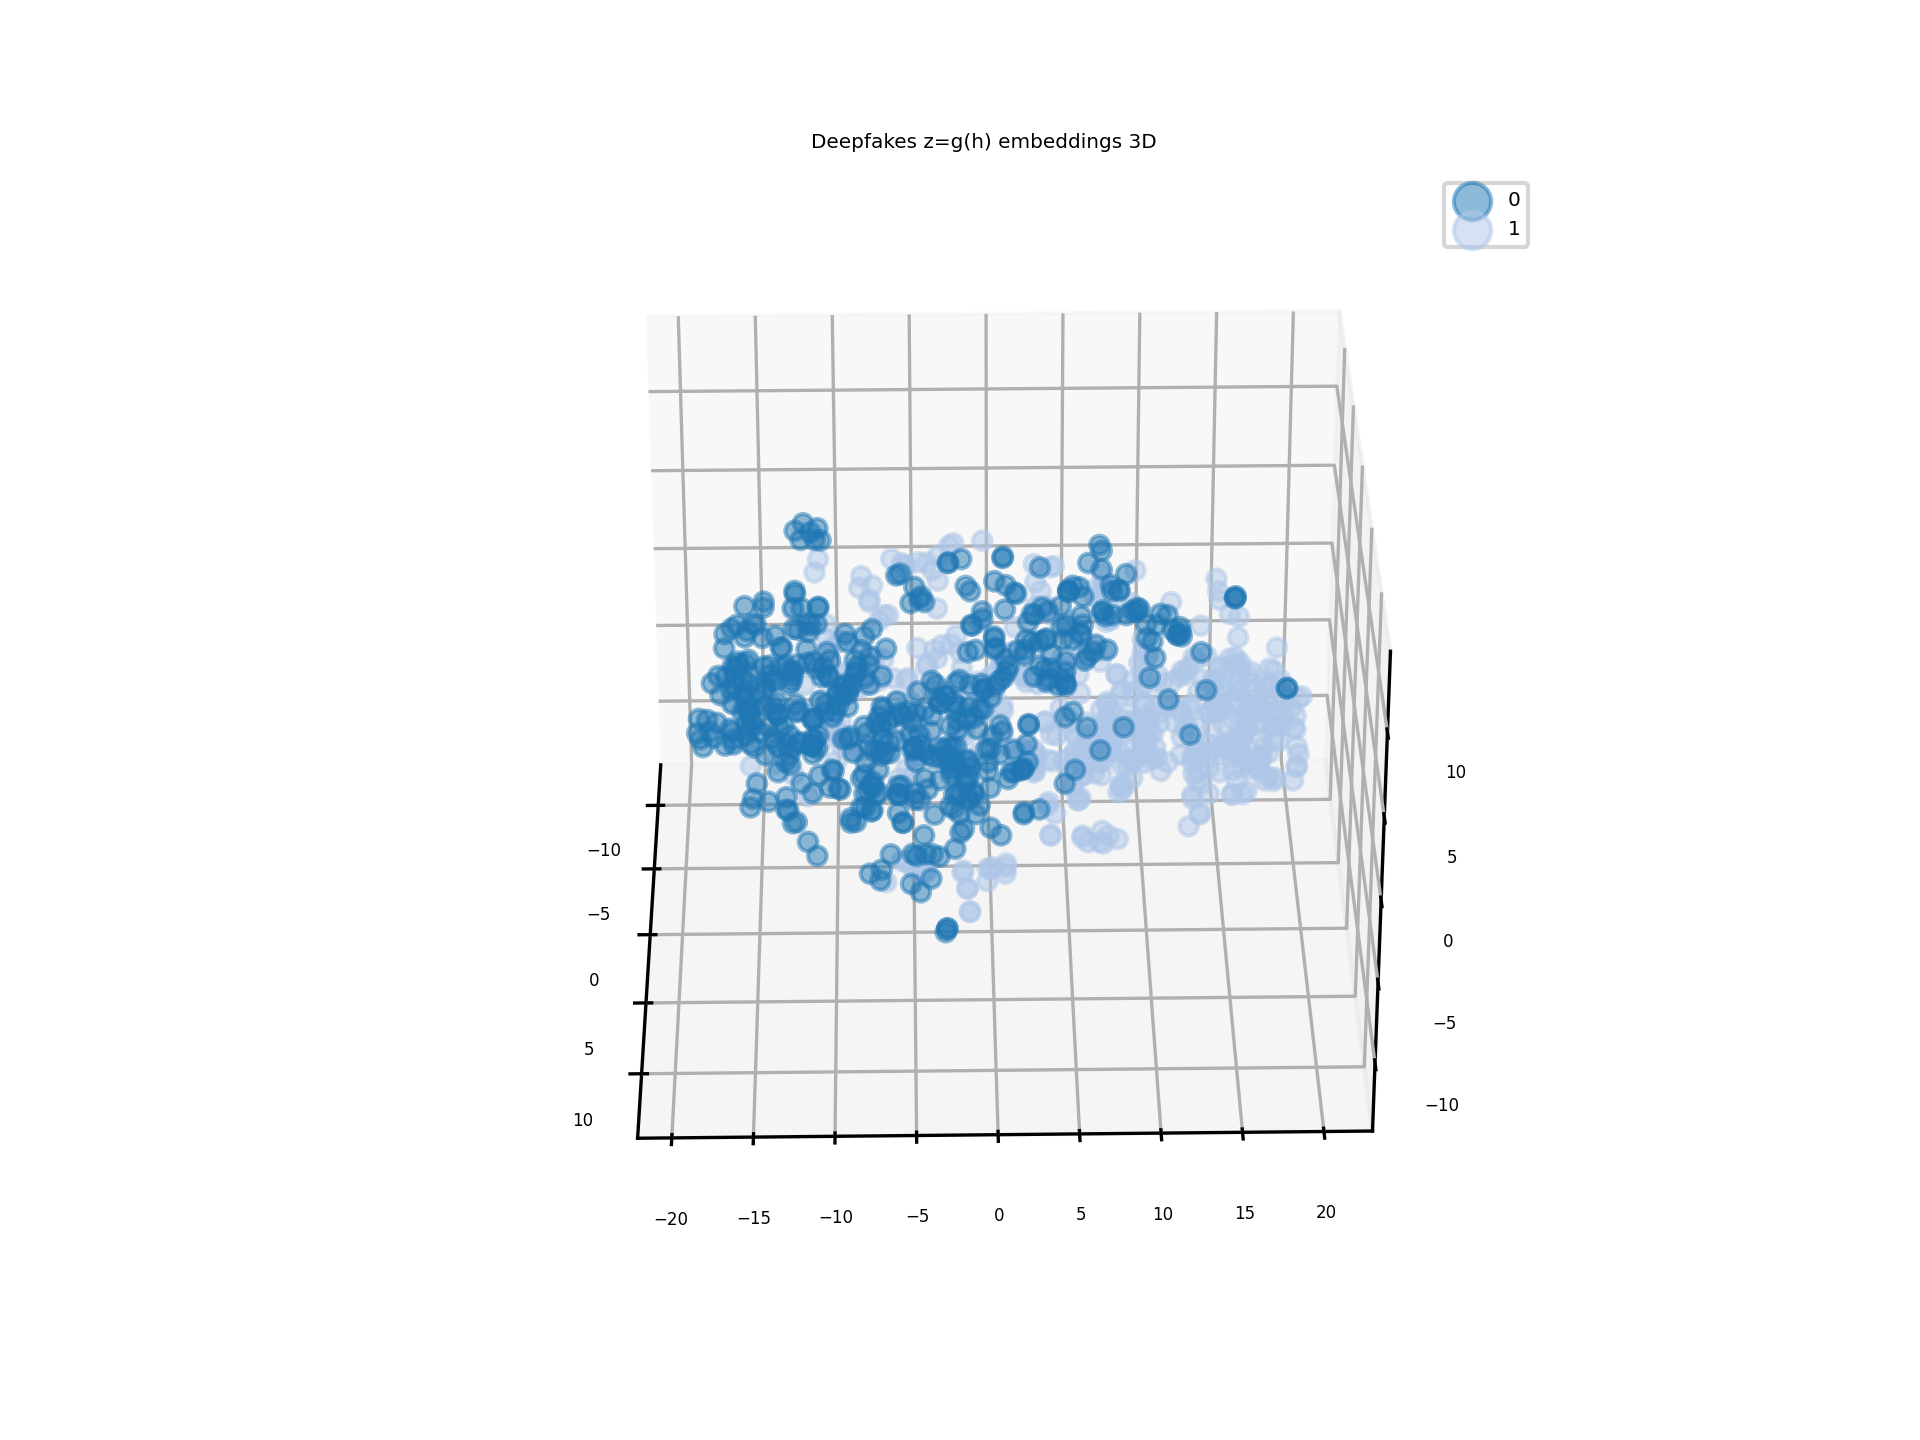

In [116]:
plot_embeddings_3D(embeds, targets, 'Deepfakes z=g(h) embeddings 3D')

## Face2Face

In [117]:
f2f_test_loader = load_ff_ds_test(1000, 16, load_face2face=True)

loading real images...
real images loaded!
loading face2face...
face2face loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 1000


In [118]:
f2f_embeds, f2f_targets = get_embeddings(model, test_loader, device)

100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


### Plot example images

In [ ]:
images, _, labels = next(iter(f2f_test_loader))
plot_images(images, labels.tolist())

### 2D Embeddings - Face2Face + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.118126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.827156
[t-SNE] KL divergence after 1000 iterations: 0.894432


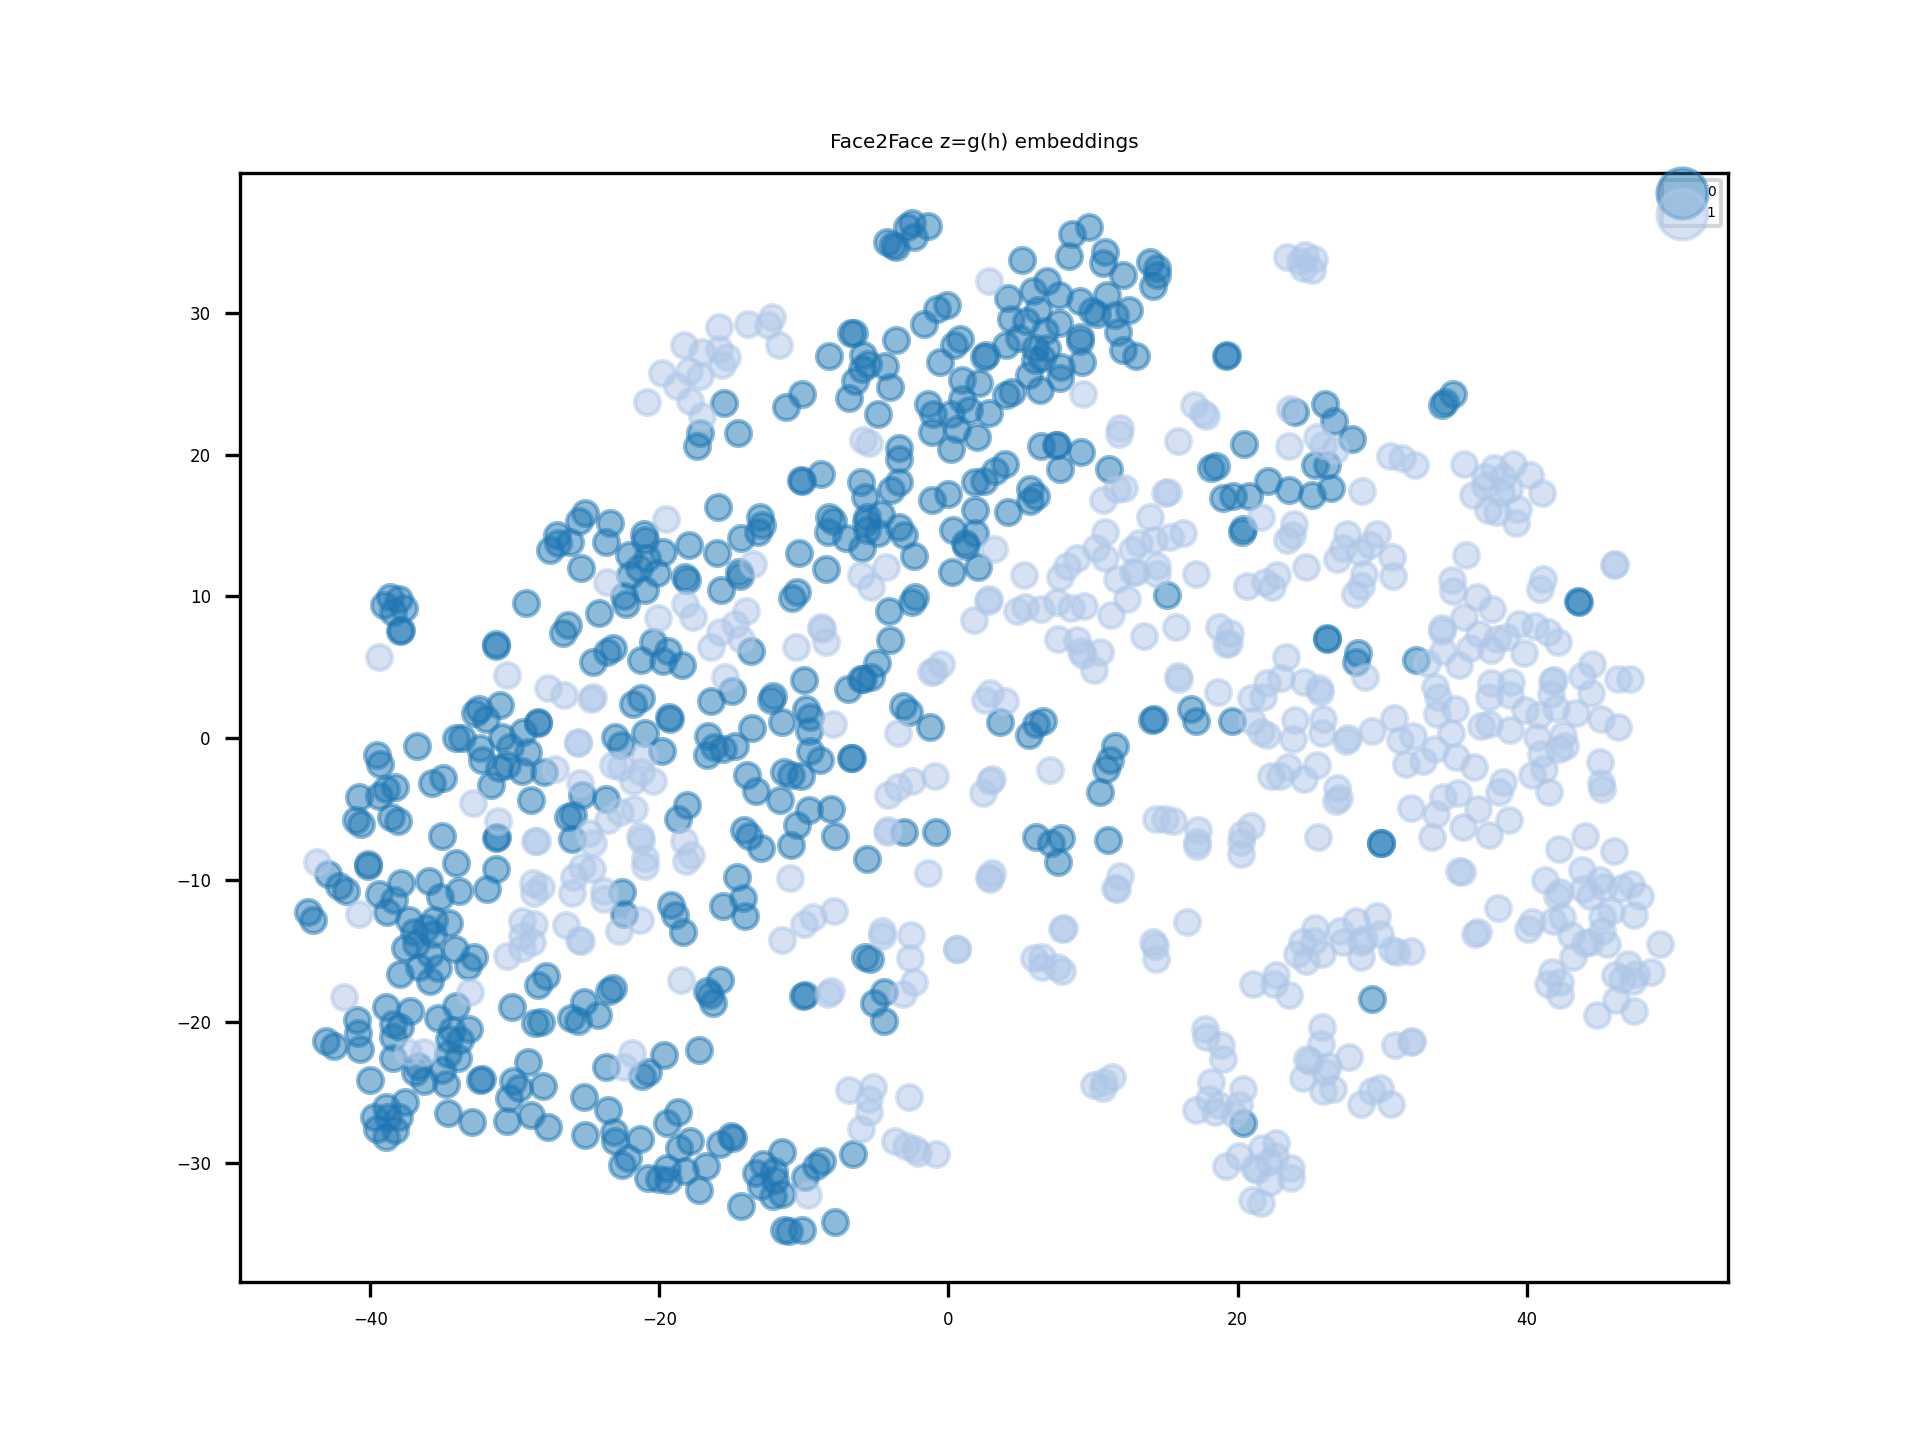

In [120]:
plot_embeddings_2D(f2f_embeds, f2f_targets, 'Face2Face z=g(h) embeddings')

### 3D Embeddings - Face2Face + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.118126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.754852
[t-SNE] KL divergence after 1000 iterations: 0.776630


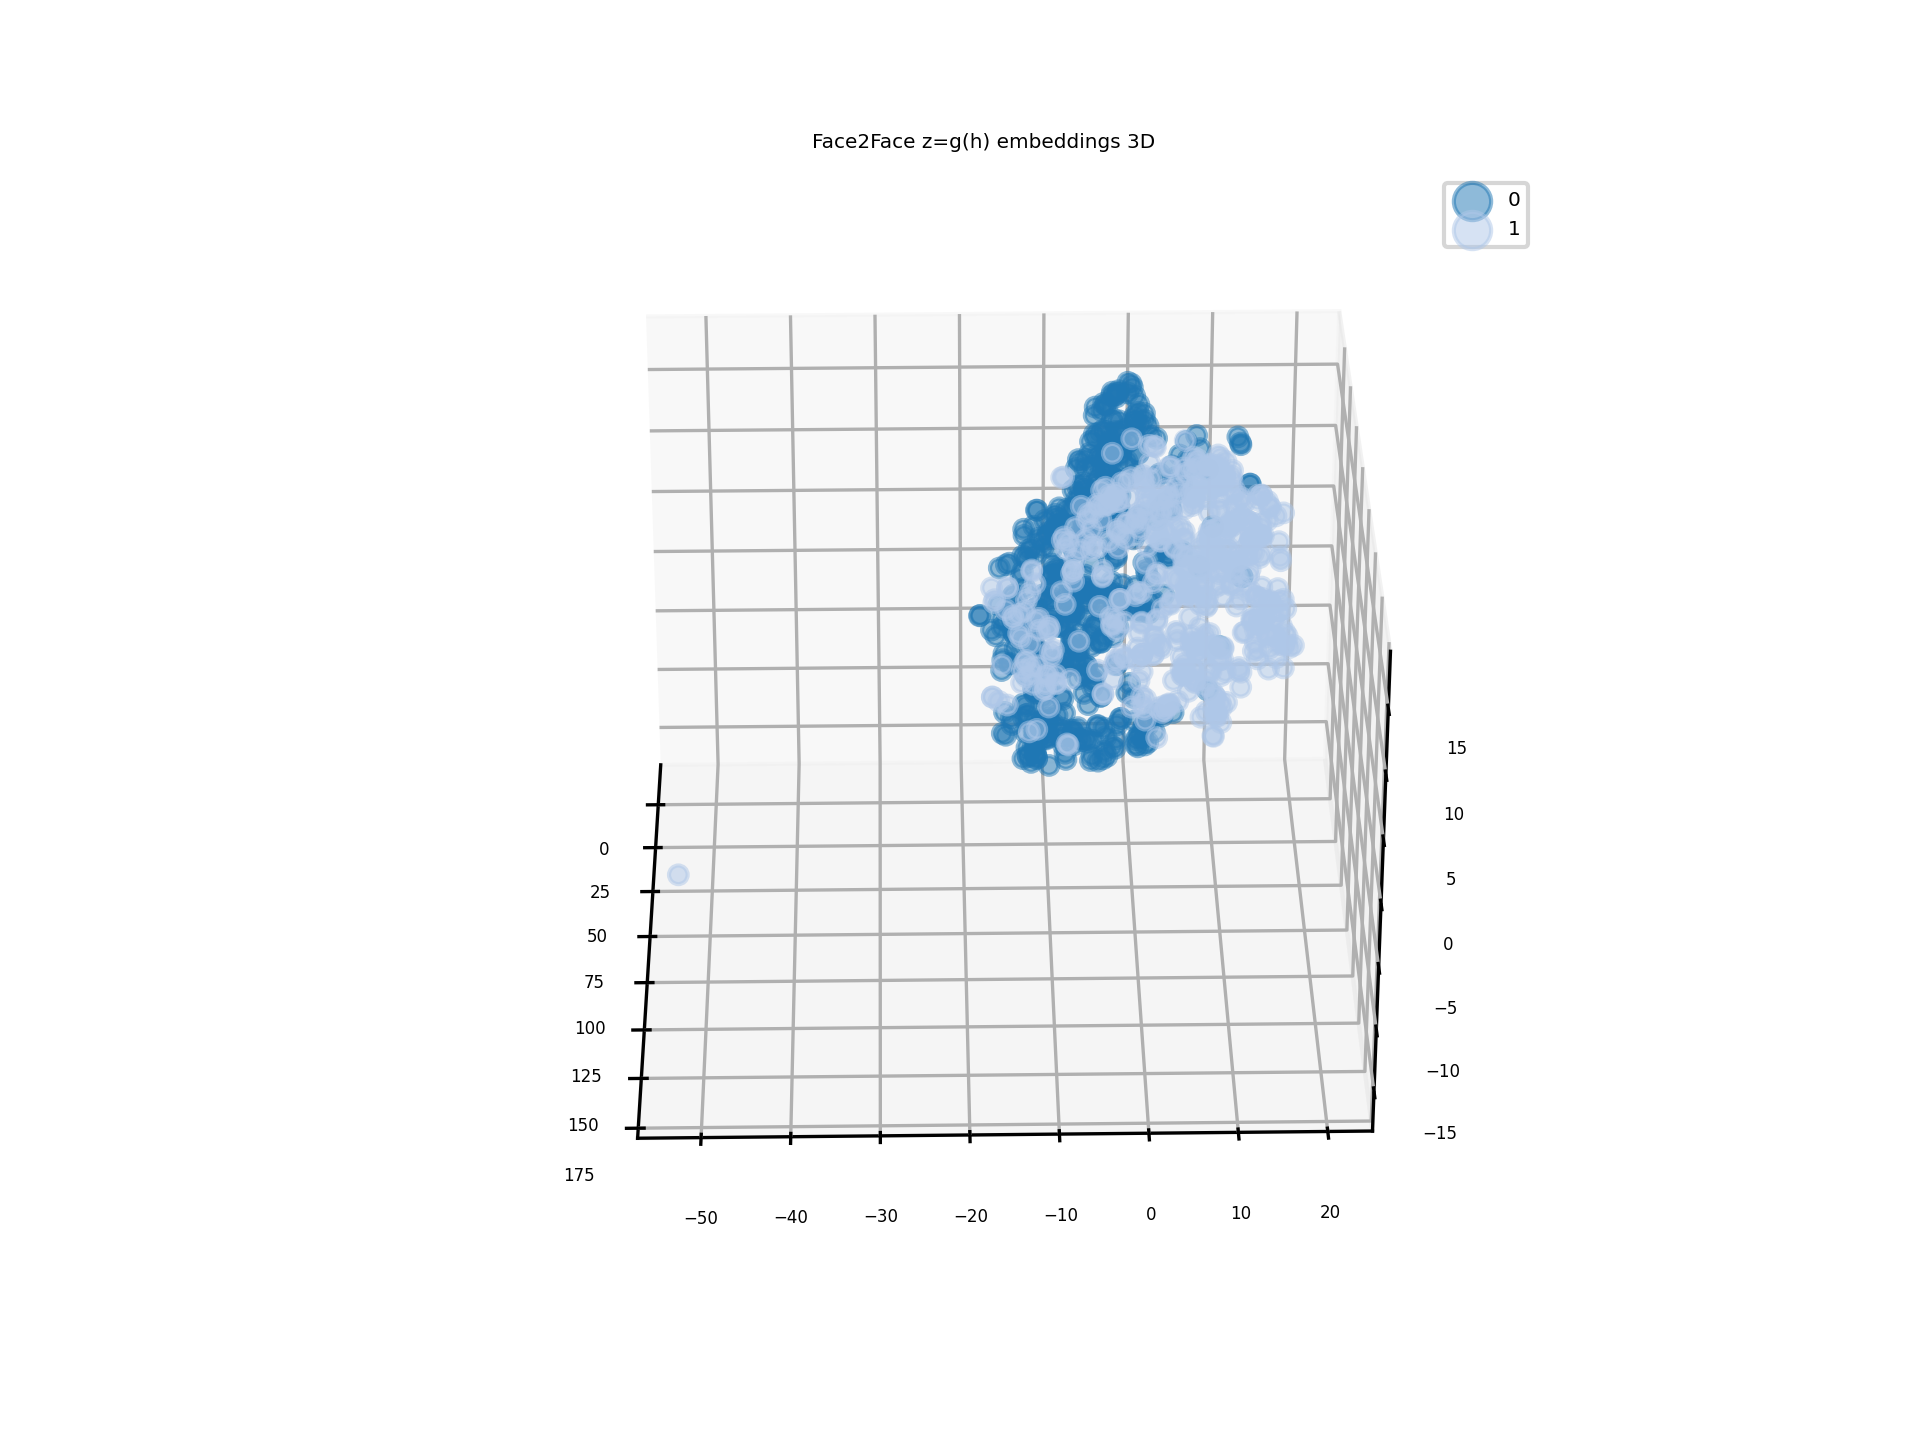

In [121]:
plot_embeddings_3D(f2f_embeds, f2f_targets, 'Face2Face z=g(h) embeddings 3D')

## NeuralTextures

In [122]:
nt_test_loader = load_ff_ds_test(1000, 16, load_neural_textures=True)

loading real images...
real images loaded!
loading neural textures...
neural textures loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 56951
fakes masks len: 56951
final imgs len: 130719
final masks len: 130719
asserting order
assertion passed!
before eq: real: 73768  fake: 56951  total: 130719
after eq: total: 130719
test size: 1000


In [124]:
nt_embeds, nt_targets = get_embeddings(model, nt_test_loader, device)

100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


### Plot example images

In [ ]:
images, _, targets = next(iter(test_loader))
plot_images(images, targets.tolist())

### 2D Embeddings - NeuralTextures + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.153970
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.831314
[t-SNE] KL divergence after 1000 iterations: 0.936661


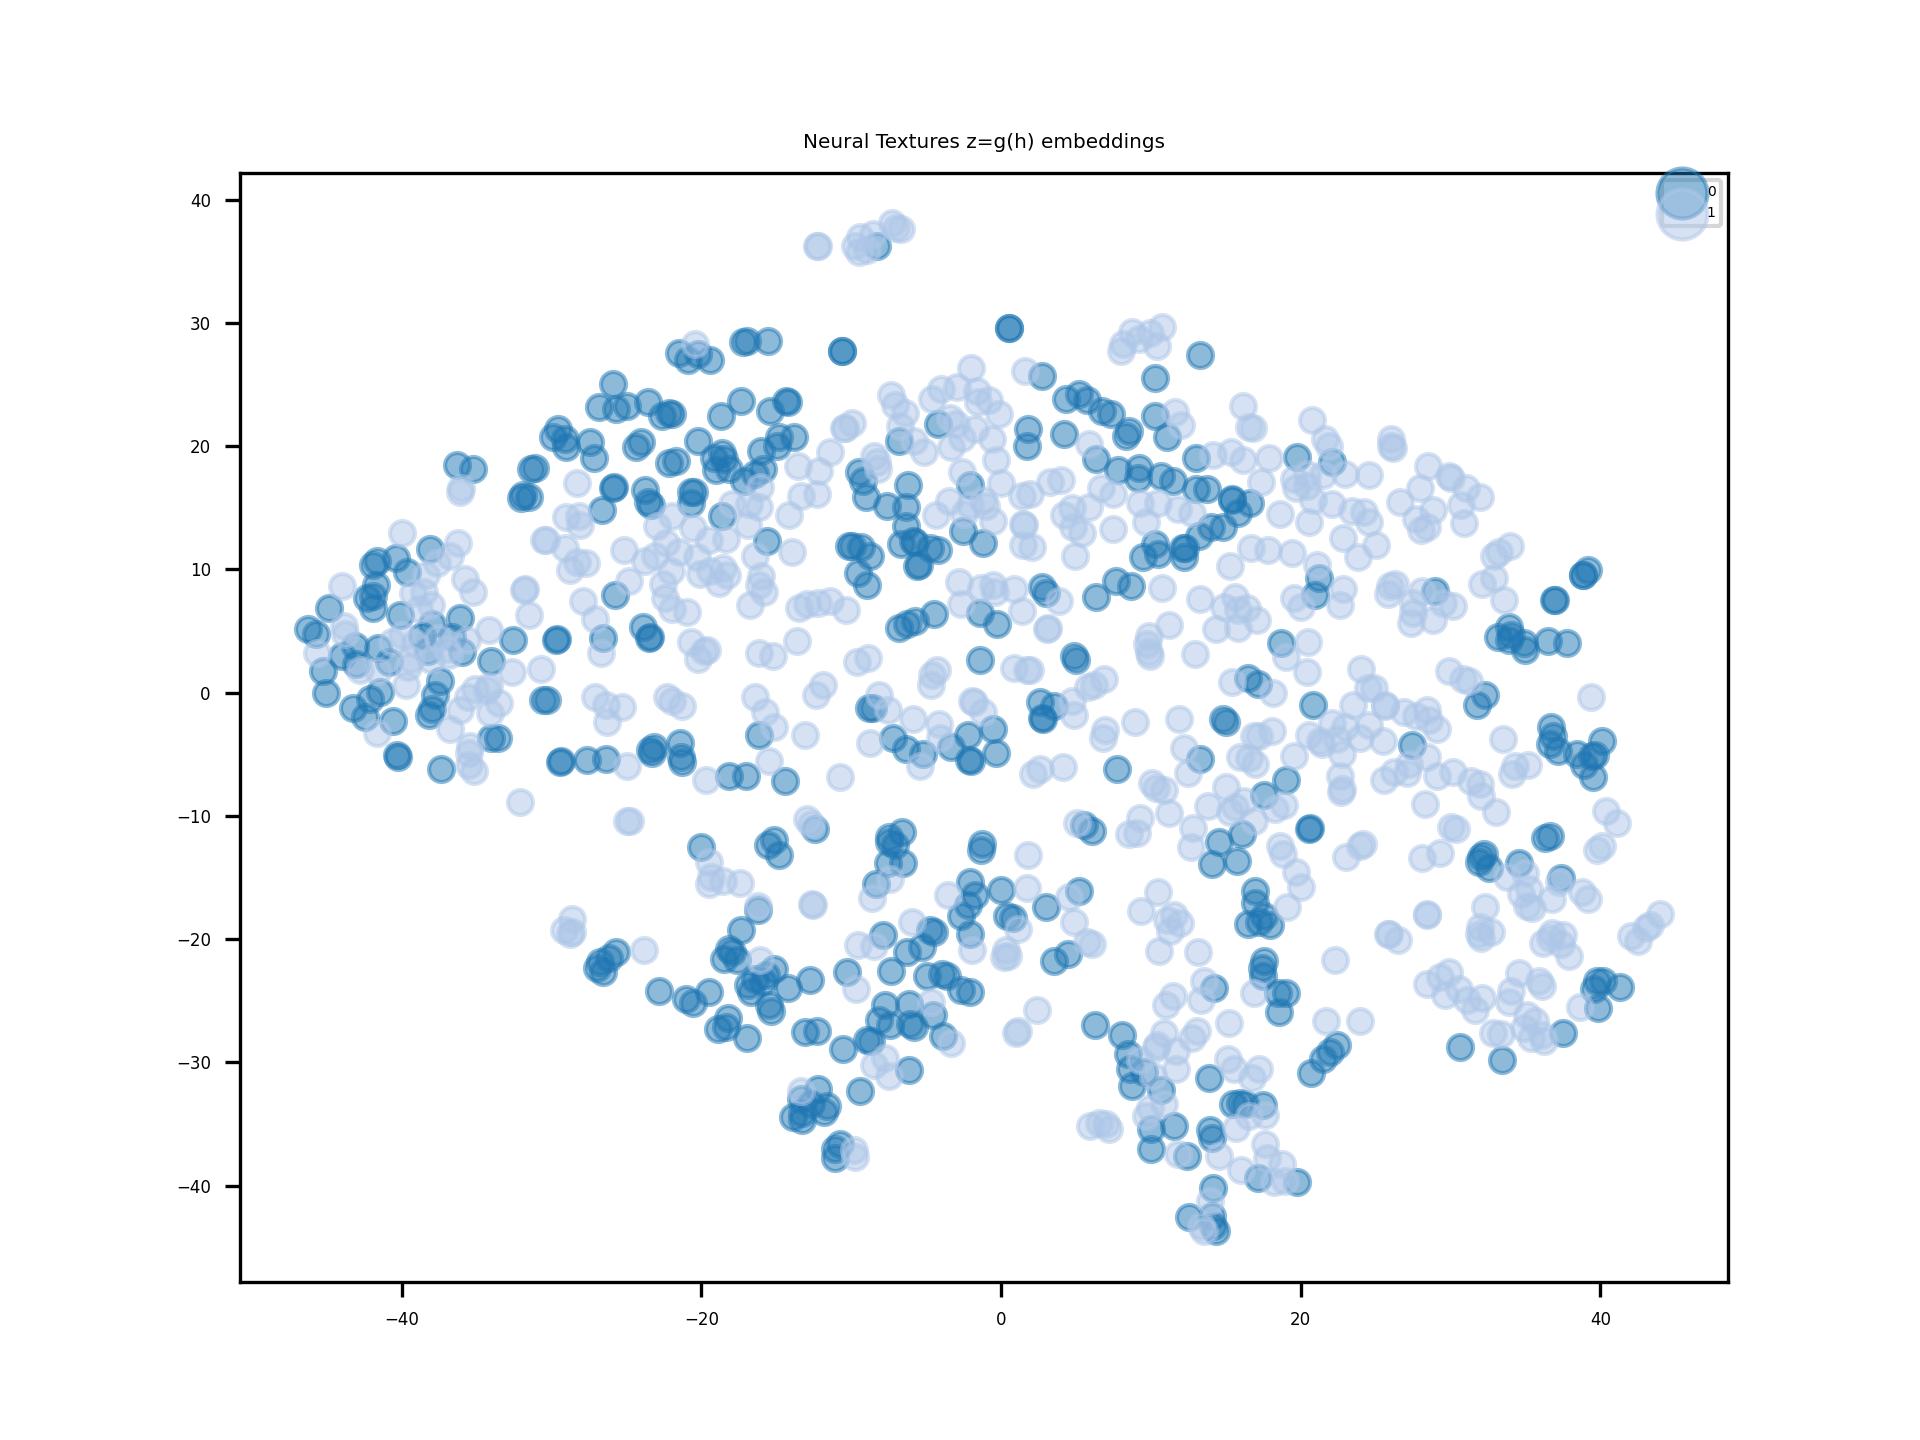

In [125]:
plot_embeddings_2D(nt_embeds, nt_targets, 'Neural Textures z=g(h) embeddings')

### 3D Embeddings - NeuralTextures + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.153970
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.047302
[t-SNE] KL divergence after 1000 iterations: 0.796487


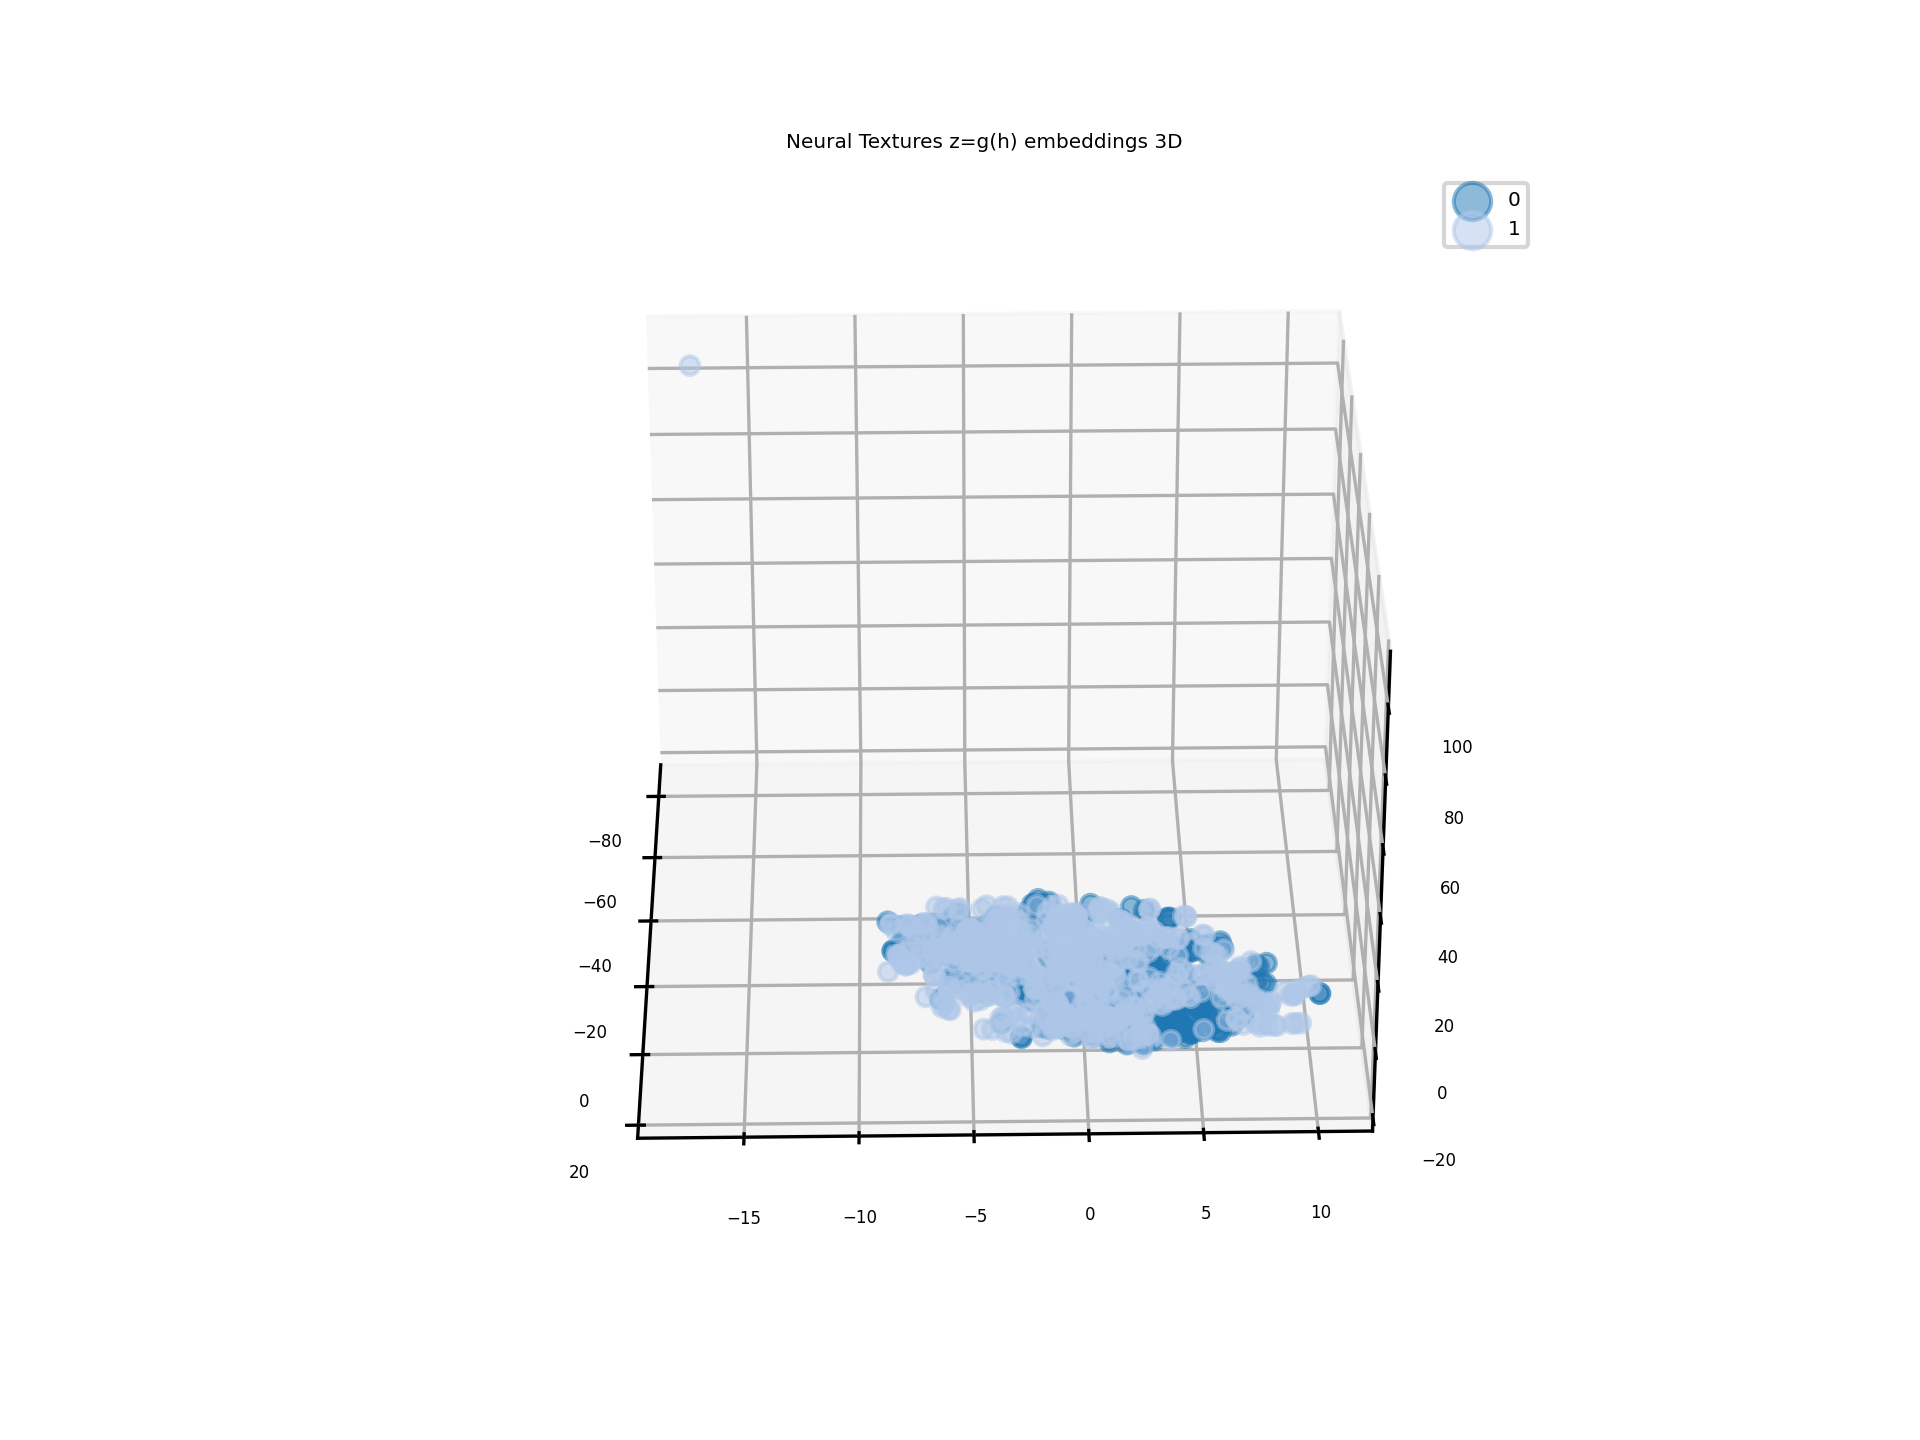

In [126]:
plot_embeddings_3D(nt_embeds, nt_targets, 'Neural Textures z=g(h) embeddings 3D')